# vinsight - Visualization Tutorial 1

in this notebook you will learn the intuition behind the features of the interpretability framework and how to us them.

## Gradient Class Activation Mapping (Grad-CAM) with ResNet

Demonstration of visualizing the class activation mapping for an image classification example with ResNet.

Additionally, you can test GradCAM AlexNet (see model_utils).


In [23]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

import data_utils
from data_utils import DataConfig
from model_utils import ModelConfig
from model_utils import split_model
from PIL import Image
import plot_utils
from vinsight.visualization import SaliencyMap
from vinsight.visualization import SpatialSplit

import torch
from torch import Tensor
from torch.nn import Softmax
from torch.nn.functional import interpolate

from torchvision import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/christina/Development/interpretability-framework/src


### Step 1: Load pretrained model

In our example we use a pretrained ResNet for demonstration.

In [24]:
device = torch.device("cuda" if torch.tensor([]).is_cuda else "cpu")

model = models.resnet50(pretrained=True)

model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Step 2: Load Image

In [25]:
img_path = "../data/imagenet_example_283.jpg"
#img_path = "../data/ood_example.jpg"

# load image as torch tensor for computation
input_ = data_utils.get_example_from_path(img_path, DataConfig.ALEX_NET)

# load image as PIL Image for plotting and resizing
img = Image.open(img_path)
H, W = img.size

## Step 3: Select spacial split
#TODO - this does nothing for now

In [26]:
layer_split = SpatialSplit()

## Step 4: Select layer of interest

in ResNet, we have 9 layers, where 8 is the last feature layer and 10 the classification layer
Input: a list of layers which should be visualized as attribution.
**Note: choose a layer between 1 and 8 for ResNet**

### Option 1: Single layer visualization
for example: layer number 7 as single layer.

In [27]:
single_layer = [7]

### Option 2: Visualization of layer attributions
for example: the mean class activation of bottom layers or top layers

In [40]:
# example ResNet selection
top_layer_attribution = [5,6,7,8]
bottom_layer_attribution = [1,2,3,4]

In [41]:
# specify the layer of interest
selected_layers = top_layer_attribution

## Step 5: Select class of interest
in this example we want to analyze the top two classes of the classification.

In [30]:
output_scores, output_classes = torch.topk(Softmax(dim=1)(model(input_).to(device)), 2)

## Step 6: Generate class activation
 compute saliency map of the selected class at the selected layer.

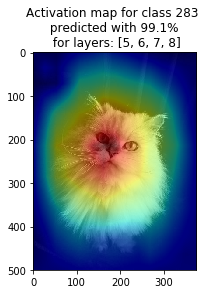

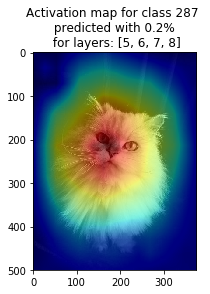

In [42]:
saliency_collector = torch.zeros((1, 1, H, W))
    
for i, (score, c) in enumerate(zip(output_scores[0], output_classes[0])):
    for layer in selected_layers:
        bottom_layers, top_layers = split_model(model, ModelConfig.RES_NET, layer)
        
        # compute saliency map
        saliency = SaliencyMap(top_layers, bottom_layers, layer_split).visualize(c, input_)
        
        # upsample saliency to the pixel dimensions of the image
        sal_map = interpolate(saliency.unsqueeze(dim=0).unsqueeze(dim=0), size=(H, W), mode='bilinear', align_corners=True)
        
        # aggregate saliencies
        saliency_collector = torch.add(saliency_collector, sal_map)
        
    if selected_layers:
        # compute mean of aggregated layer saliencies
        mean_activation = torch.div(saliency_collector, len(selected_layers))
        plot_utils.plot_saliency(mean_activation, img, c, score, selected_layers)
        
    else: 
        print("no layers selected.")